## Intro

[Good news everyone!](https://www.youtube.com/watch?v=ZxoNhqmEsnY) It's an easier day today `:)`

The purpose of today's class is to explore data using **interactive visualizations**. Interactivity is a key part of modern dataviz. It's a way to allow users of your visualizations get their own feel for the data ... to create richer visualization, where people who use your work can expose more of the data by exploring.

## Part 1: Video Lectures and Reading

Starting this week, we'll be playing around with *explanatory data visualization*. Roughly speaking this means using data visualization to communicate your results to others. Thus, there are new things to think about. 

Until today we have worked with static data visualization. However, exploratory data analysis means to be able to explore the multi-faceted nature of data and *interactive dataviz* is a handy tool to do it! It allows to play with the data: Toggle the view. Zoom. Drag. Show more details. All those things. Those are a key part of modern data visualization. 

The video below provides context about these points.

We start with the video and then read a bit from a scientific article about types of explanatory dataviz. (*The video is from an old version of the class that used D3, so just ignore those parts.*).

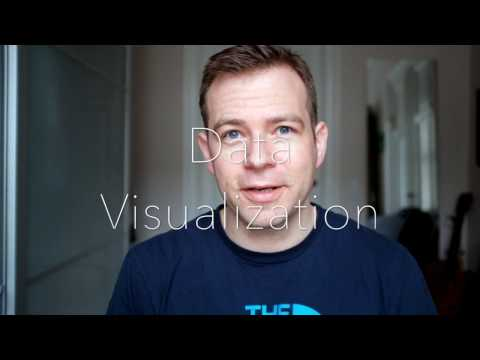

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('yHKYMGwefso', width=800, height=450)

> *Exercises*: Explanatory data visualization. 
> * What are the three key elements to keep in mind when you design an explanatory visualization?
> * In the video I talk about (1) *overview first*,  (2) *zoom and filter*,  (3) *details on demand*. 
>   - Go online and find a visualization that follows these principles (don't use one from the video). 
>   - Explain how your video achieves (1)-(3). It might be useful to use screenshots to illustrate your explanation.
> * Explain in your own words: How is explanatory data analysis different from exploratory data analysis?
>
> **Note**. Keep your answers to the questions above short and sweet.

<div class="alert alert-block alert-info">
Try to answer these using your human brain.
</div>

# Data Preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, FactorRange, Legend
from bokeh.io import output_file
import bokeh.palettes as palettes

In [3]:
# Get data
IRH_first = pd.read_csv('data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
IRH_second = pd.read_csv('data/Police_Department_Incident_Reports__2018_to_Present_20250204.csv')

# Select relevant columns
IRH_first = IRH_first[['Category', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'location', 'X', 'Y']]
IRH_second = IRH_second[['Incident Category', 'Incident Day of Week', 'Incident Date', 'Incident Time', 'Police District', 'Point', 'Longitude', 'Latitude']]

# Rename columns
merged_column_names = ['Category', 'DayOfWeek', 'Date', 'Time', 'District', 'PointLocation', 'Longitude', 'Latitude']
IRH_first.columns = merged_column_names
IRH_second.columns = merged_column_names

# Prepare to concatenate
IRH_second['Category'] = IRH_second['Category'].str.upper()
IRH_second['District'] = IRH_second['District'].str.upper()
IRH_first['Date'] = pd.to_datetime(IRH_first['Date'])
IRH_second['Date'] = pd.to_datetime(IRH_second['Date'])

In [4]:
# Make consistent category mapping
category_mapping = {
    'LARCENY THEFT': 'LARCENY/THEFT',
    'LARCENY/THEFT': 'LARCENY/THEFT',
    'BURGLARY': 'BURGLARY',
    'MOTOR VEHICLE THEFT': 'VEHICLE THEFT',
    'MOTOR VEHICLE THEFT?': 'VEHICLE THEFT',
    'VEHICLE THEFT': 'VEHICLE THEFT',
    'DRUG OFFENSE': 'DRUG/NARCOTIC',
    'DRUG VIOLATION': 'DRUG/NARCOTIC',
    'DRUG/NARCOTIC': 'DRUG/NARCOTIC',
    'FORGERY AND COUNTERFEITING': 'FORGERY/COUNTERFEITING',
    'FORGERY/COUNTERFEITING': 'FORGERY/COUNTERFEITING',
    'SEX OFFENSES, FORCIBLE': 'SEX OFFENSE',
    'SEX OFFENSES, NON FORCIBLE': 'SEX OFFENSE',
    'SEX OFFENSE': 'SEX OFFENSE',
    'WEAPON LAWS': 'WEAPON LAWS',
    'WEAPONS CARRYING ETC': 'WEAPON LAWS',
    'WEAPONS OFFENCE': 'WEAPON LAWS',
    'WEAPONS OFFENSE': 'WEAPON LAWS',
    'WARRANT': 'WARRANTS',
    'WARRANTS': 'WARRANTS',
    'OTHER': 'OTHER',
    'OTHER MISCELLANEOUS': 'OTHER',
    'OTHER OFFENSES': 'OTHER',
    'HUMAN TRAFFICKING, COMMERCIAL SEX ACTS': 'HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS',
    'SUSPICIOUS': 'SUSPICIOUS OCC',
    'MALICIOUS MISCHIEF': 'VANDALISM'
}
# OBS: Liqour law could be made DRUNKENESS. How to merge - Driving under the influence and Trespass. If we dont we do not have data after 2018.
IRH_first['Category'] = IRH_first['Category'].replace(category_mapping)
IRH_second['Category'] = IRH_second['Category'].replace(category_mapping)

In [5]:
# Concatenate
IRH_all = pd.concat([IRH_first, IRH_second])

# Use only full years
IRH_all = IRH_all[
    (IRH_all['Date'] >= pd.to_datetime('2014-01-01', format='%Y-%m-%d')) &
    (IRH_all['Date'] < pd.to_datetime('2025-01-01', format='%Y-%m-%d'))
]

# Add separated date columns and time column
IRH_all['Year'] = IRH_all['Date'].dt.year
IRH_all['Month'] = IRH_all['Date'].dt.month
IRH_all['Day'] = IRH_all['Date'].dt.day
IRH_all['Hours'] = IRH_all['Time'].str[:2].astype(int)
IRH_all['Minutes'] = IRH_all['Time'].str[3:].astype(int)

# The dataset, IRH_all, will be the basis of our assignment.
focuscrimes = ['WEAPON LAWS', 'PROSTITUTION', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUG/NARCOTIC', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY']

## Part 2: Interactive visualizations with Bokeh



To really master interactive visualizations, you will need to work with JavaScript, especially [D3](https://d3js.org). Given the limited time available for this class, we can't squeeze that in. But luckily Python has some pretty good options for interactive visualizations. You can find a range of different options [here](https://mode.com/blog/python-interactive-plot-libraries/).

Today, we'll explore [`Bokeh`](https://docs.bokeh.org/en/latest/), which provides lots of nice interactive funtionalities to Python. To work with Bokeh, we first set up our system:

1. If you haven't installed it yet please do so. You can simply follow [these steps](https://docs.bokeh.org/en/latest/docs/first_steps/installation.html)

2. To include Bokeh in your notebooks you can follow the [Bokeh: Using with Jupyter](https://docs.bokeh.org/en/latest/docs/user_guide/output/jupyter.html#jupyter) guide. Come back to this one when you need it

3. We aim to give you a gentle start with Bokeh and I am going to include more example code than usual in the follwing.
   * **HINT 1**: If you're not an experienced Python user, I recommend going to the [official user's guide](https://docs.bokeh.org/en/latest/docs/user_guide.html#userguide) and working through it. Start by clicking "Introduction" in the linked page. That page has a glossary, a section on output methods, stuff on settings, and interfaces that you can scroll through. The next page *Basic Plotting* where the action is. Spend some time working through that.
   * **HINT 2**: And by "working through it", I mean copy, paste, and run the code in your own notebook. 

Ok. Let's get started. First a general announcement on the data.

> **Announcement**
> * During this entire lecture, as always, we are going to work with the SF Crime Data. 
> * We will use data for the **period 2014-2024** (Jan 1st 2014 to Dec 31 2024).
> * We'll consider only the 10 focus crimes.


Now, to get you in the mood here's a little gif to illustrate what the goal of this exercise is:

![Movie](https://raw.githubusercontent.com/suneman/socialdata2025/main/files/Week6_1.gif)

If the gif isn't displaying on your system, you can download it [here](https://github.com/suneman/socialdata2025/blob/main/files/Week6_1.gif) and display locally.


> ***Exercise***: Recreate a new version of the results from **Week 2** (with updated dates) as an interactive visualisation (shown in the gif). To complete the exercise, follow the steps below to create your own version of the dataviz.

<div class="alert alert-block alert-info">
To learn about Bokeh and how it works, try to do this without LLM help. Only use if you get totally stuck after having tried all the various hints, and read the documentation. (Plus, notice the text en gray about the caption at the very end.)
</div>

### Data prep

A key step is to set up the data right. So for this one, we'll be pretty strict about the steps. The workflow is

1. Take the data for the period of 2014-2024 and group it by hour-of-the-day.
2. We would like to be able to easily compare how the distribution of crimes differ from each other, not absolute numbers, so we will work on *normalized data*:
    * To normalise data for within a crime category you simply to devide the count for each hour by the total number of this crime type. (To give a concrete example in the `DRUG/NARCOTIC` category, take the number of drug/narcotics-counts in 1st hour you should devide by the total number of drug/narcotic arrests, then you devide number of drug/narcotics-counts in 2nd hour by the total number of drug/narcotics arrests and so on)
    *  Your life will be easiest if you organize your dataframe as shown in [this helpful screenshot](https://github.com/suneman/socialdata2025/blob/main/files/W6_Part2_data.png).

If you've followed these steps, your data should be ready! Take a moment to celebrate. Below, we follow the [Bokeh guide for categorical data](https://docs.bokeh.org/en/latest/docs/user_guide/basic/bars.html).


1. First, let's convert our **Pandas Dataframe** to **Bokeh ColumnDataSource**:
   
  > ```python
  > source = ColumnDataSource(your_processed_dataframe)
  > ## it is a standard way to convert your df to bokeh
  > ```

2. We also need to create an empty figure (we will add our stuff here later on). Mini sub-exercise: Find the a guide how to define a figure in Bokeh online. Here is a little help:
  
  > ```python
  > p = figure(...., x_range = FactorRange(factors=hours), ...) 
  > #p is a standard way to call figures in Bokeh
  > #make sure to add x_range. In my case hours is a list on the form ['1', '2', '3' ... , '24']
  > #read up on the FactorRange in the guide
  > #do not forget to add other attributes to the figure, e.g. title, axis names and so on
  > ```

3. Now we are going to add the bars. In order to do so, we will use **vbar** (see the guide for help):
  
  > ```python
  > bar ={} # to store vbars
  > ### here we will do a for loop:
  > for indx,i in enumerate(focuscrimes):
  >     bar[i] = p.vbar(x='name_of_the_column_that_contain_hours',  top=i, source= src, 
  >                     ### we will create a vbar for each focuscrime
  >                     legend_label=i,  muted_alpha=..., muted = ....) 
  > #i stands for a column that we use, top=y; we are specifying that our numbers comes from column i
  > #read up what legend_label, muted and muted_alpha do... you can add more attributes (you HAVE TO)
  > ```

4. The last thing to do is to make your legend interactive and display the figure:
  
  > ```python
  > p.legend.click_policy="mute" ### assigns the click policy (you can try to use ''hide'
  > show(p) #displays your plot
  > ```

5. You will notice that the legend appears in the middle of the figure (and it occludes some of the data). In order to fix this look into [this guide](https://stackoverflow.com/questions/26254619/position-of-the-legend-in-a-bokeh-plot) as a start. <p style="color: gray;">It is OK to use an LLM for help on this part - the Bokeh documentation has changed over time, so this part is a little tricky.</p>
  
Now you should be able to recreate this amazing visualisation.


**EXTRA feature**: If you're interested in detailed instructions for more Bokeh visualizations for your final project, you can find more inspiration **[here](https://github.com/suneman/socialdata2021/blob/main/lectures/Week8_extra_bokeh.ipynb)**.

## Exploration of the Data

In [6]:
output_notebook()
print(f"Dataset covers years: {IRH_all['Year'].min()} to {IRH_all['Year'].max()}")
print(f"Total number of incidents: {len(IRH_all)}")
print(f"Focus crimes distribution:")
focus_counts = IRH_all[IRH_all['Category'].isin(focuscrimes)]['Category'].value_counts()
print(focus_counts)

Loading BokehJS ...

Dataset covers years: 2014 to 2024
Total number of incidents: 1558166
Focus crimes distribution:
Category
LARCENY/THEFT      453883
ASSAULT            106033
VANDALISM          100112
VEHICLE THEFT       79369
BURGLARY            76946
DRUG/NARCOTIC       42787
ROBBERY             35245
WEAPON LAWS         18688
STOLEN PROPERTY      8365
PROSTITUTION         2953
Name: count, dtype: int64


## Prepare hourly data for Bokeh visualization

In [7]:
def prepare_hourly_crime_data(data, focus_crimes):
    """
    Prepare crime data grouped by hour of the day and normalized within each crime category
    """
    # Filter data for focus crimes and time period 2014-2024
    filtered_data = data[data['Category'].isin(focus_crimes)]
    
    # Group by hour and crime category
    hour_counts = filtered_data.groupby(['Hours', 'Category']).size().reset_index(name='Count')
    
    # Calculate total counts for each crime category
    category_totals = hour_counts.groupby('Category')['Count'].sum().reset_index(name='Total')
    
    # Merge totals back to get normalized values
    hour_counts = hour_counts.merge(category_totals, on='Category')
    hour_counts['Normalized'] = hour_counts['Count'] / hour_counts['Total']
    
    # Pivot to get one column per crime category
    pivot_data = hour_counts.pivot(index='Hours', columns='Category', values='Normalized').reset_index()
    
    # Fill any missing values with 0
    pivot_data = pivot_data.fillna(0)
    
    # Convert Hours to strings for categorical x-axis
    pivot_data['Hours'] = pivot_data['Hours'].astype(str)
    
    return pivot_data

# Prepare data for visualization
hour_data = prepare_hourly_crime_data(IRH_all, focuscrimes)

# Display the first few rows of the prepared data
hour_data.head()

Category,Hours,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,PROSTITUTION,ROBBERY,STOLEN PROPERTY,VANDALISM,VEHICLE THEFT,WEAPON LAWS
0,0,0.048975,0.054571,0.030523,0.042969,0.098544,0.046503,0.048177,0.054049,0.039990,0.054099
1,1,0.043279,0.036766,0.018253,0.023766,0.058584,0.047666,0.027735,0.034082,0.022351,0.041685
2,2,0.037658,0.047033,0.016197,0.015698,0.048425,0.045283,0.027376,0.031625,0.018584,0.036708
3,3,0.020465,0.056754,0.012621,0.012102,0.033864,0.027862,0.023072,0.027899,0.015157,0.027665
4,4,0.015061,0.056234,0.007806,0.008996,0.015916,0.019634,0.021279,0.022475,0.012272,0.018729


## Create and display the Bokeh visualization

In [11]:
# Convert DataFrame to Bokeh ColumnDataSource
source = ColumnDataSource(hour_data)

# Create the figure
hours = [str(h) for h in range(24)]  # Hours as strings: '0', '1', '2', ..., '23'

p = figure(
    title="Normalized Hourly Distribution of SF Crimes (2014-2024)",
    x_range=FactorRange(factors=hours),
    height=500,
    width=900,
    toolbar_location="right",
    tools="pan,wheel_zoom,box_zoom,reset,save",
    x_axis_label="Hour of Day",
    y_axis_label="Normalized Frequency"
)

# Add bars for each crime category
# Use a color palette with enough colors for all focus crimes
num_colors = len(focuscrimes)
colors = palettes.Category10[10] if num_colors <= 10 else palettes.Category20[20][:num_colors]

# Create empty dictionary to store vbars
bars = {}

# Add vbars for each crime category
for i, crime in enumerate(focuscrimes):
    bars[crime] = p.vbar(
        x='Hours',           # x-coordinates (hours)
        top=crime,           # y-coordinates (normalized values from each crime column)
        source=source,
        width=0.8,           # width of bars
        color=colors[i],     # color from palette
        legend_label=crime,  # legend label
        muted_alpha=0.2,     # alpha when muted
        muted=False          # not muted initially
    )

# Configure the legend to be interactive
p.legend.click_policy = "mute"

# Move the legend outside the plot area to avoid occlusion
p.add_layout(p.legend[0], 'right')

# Style the legend
p.legend.background_fill_alpha = 0.7
p.legend.border_line_color = "black"
p.legend.border_line_width = 1
p.legend.label_text_font_size = "8pt"

# Add grid lines for better readability
p.grid.grid_line_color = "gray"
p.grid.grid_line_alpha = 0.3
p.grid.minor_grid_line_alpha = 0.1

# Format y-axis
p.yaxis.formatter.use_scientific = False
p.y_range.start = 0  # Start from 0

# Remove toolbar logo
p.toolbar.logo = None

# Show the plot
show(p)
output_file("assets/plots/sf_crime_hourly_distribution.html")

## Analysis of the visualization

Based on the interactive visualization, we can observe several patterns:

1. **LARCENY/THEFT** shows peaks during daylight and early evening hours, likely coinciding with 
   periods of higher public activity and retail operations.

2. **VEHICLE THEFT** appears to have a more even distribution throughout the day, with 
   slight increases during the overnight hours when vehicles are parked and unattended.

3. **DRUG/NARCOTIC** offenses tend to cluster in the afternoon and early evening hours.

4. **ROBBERY** incidents show increased frequency during evening hours.

5. **ASSAULT** cases tend to rise in the evening and night hours, possibly 
   corresponding to nightlife activities.

The normalized distribution allows us to compare patterns between crime types regardless of their 
overall frequency. The interactive legend makes it easy to focus on specific crime categories 
by clicking to mute others.

These hourly patterns can provide valuable insights for law enforcement resource allocation 
and crime prevention strategies.

## Part 3: Narrative Dataviz

Let's finish up with some reading

*Reading*: [Narrative Visualization: Telling Stories with Data](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf) by Edward Segel and Jeffrey Heer. We'll read section 1-3 today. (And the rest a bit later).

When you get to section 3 it's fun to open up the examples mentioned by the authors in a browser and explore them as you read the text. 

> *Exercise*: Answer a couple of questions about the paper.
> 
> * What is the *Oxford English Dictionary's* defintion of a narrative?
* an account of a series of events, facts, etc., given in order and with the establishing of connections between them.
> * What is your favorite visualization among the examples in section 3? Explain why in a few words.
* Probably the animation in figure 5 since it is not too complicated have a nice look and gives an easy overview

<div class="alert alert-block alert-info">
For this one, read the text with your human brain and try to answer on your own too.
</div>